# Canada's DataFarm Crops — Initial Data Overview

[ENG]
This notebook represents the first phase of Exploratory Data Analysis (EDA) on the dataset of Canadian agricultural crops.
It includes preliminary operations such as data import, structural inspection, type identification, checking for missing values, and descriptive statistics.
The goal is to become familiar with the structure of the dataset before proceeding with cleaning and visualization.

[IT]
Questo notebook rappresenta la prima fase di analisi esplorativa (EDA) del dataset sulle coltivazioni agricole canadesi.  
Contiene le operazioni preliminari di importazione, verifica struttura dei dati, identificazione dei tipi, eventuali valori nulli e statistiche descrittive.  
Lo scopo è familiarizzare con la struttura del dataset prima della pulizia e visualizzazione.

### 1. Data Exploration and Understanding

In [34]:
# Main libraries for data analysis
import pandas as pd          # Data manipulation and analysis
import numpy as np           # Numerical computations and array handling
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns        # Statistical data visualization

# Display settings for better readability
pd.set_option('display.max_columns', None)   # Show all columns when displaying a DataFrame
pd.set_option('display.precision', 2)        # Display float numbers with 2 decimal places

# Set Seaborn theme for nicer plots
sns.set(style='whitegrid')   # Use white background with gridlines for clarity

# Enable inline plotting in Jupyter Notebooks (if applicable)
%matplotlib inline

In [35]:
# Load the dataset from the raw data folder
df = pd.read_csv("../data_raw/farm_production_dataset.csv")

In [36]:
# Check the number of rows and columns in the dataset
print("Shape of the dataset:")
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

Shape of the dataset:
Rows: 10273
Columns: 9


In [37]:
# Preview the first 5 rows to understand the structure
df.head()

,REF_DATE,GEO,Type of crop,Average farm price (dollars per tonne),Average yield (kilograms per hectare),Production (metric tonnes),Seeded area (acres),Seeded area (hectares),Total farm value (dollars)
0,1908,AB,Barley,15.00,1585.0,84000.0,129800.0,53000.0,1296
1,1908,AB,Flaxseed,29.00,950.0,1900.0,5900.0,2000.0,56
2,1908,AB,Oats,18.00,1675.0,352000.0,519400.0,210000.0,6316
3,1908,AB,"Rye, all",23.00,1665.0,5000.0,6500.0,3000.0,117
4,1908,AB,Sugar beets,0.55,18100.0,38100.0,5200.0,2100.0,208


In [38]:
# Check the data types of each column
df.dtypes

REF_DATE                                    int64
GEO                                        object
Type of crop                               object
Average farm price (dollars per tonne)    float64
Average yield (kilograms per hectare)     float64
Production (metric tonnes)                float64
Seeded area (acres)                       float64
Seeded area (hectares)                    float64
Total farm value (dollars)                  int64
dtype: object

In [39]:
# Check for missing values (NaN) in each column
missing_values = df.isnull().sum()

# Calculate the percentage of missing values
missing_percentage = (missing_values / len(df)) * 100

# Combine the count and percentage in a single DataFrame
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage.round(2)
})

# Display only columns with missing values
missing_data[missing_data['Missing Values'] > 0]

,Missing Values,Percentage (%)
Type of crop,1,0.01
Average farm price (dollars per tonne),30,0.29
Average yield (kilograms per hectare),27,0.26
Production (metric tonnes),28,0.27
Seeded area (acres),400,3.89
Seeded area (hectares),426,4.15


### 2. Data Cleaning and Preparation

### 1. Remove rows with missing crop types
This step removes any rows where the 'Type of crop' field is missing. Since the percentage is only 0.01%, this operation has negligible impact.


In [19]:
# Drop rows with missing 'Type of crop' (only 1 row missing, negligible impact)
df = df.dropna(subset=["Type of crop"])

### Step 2 – Impute missing values in 'Average farm price'
We fill missing values in the 'Average farm price' column using the mean price calculated for each specific crop type. This preserves logical consistency within the data.


In [20]:
# Fill missing 'Average farm price' values using the mean per crop type
df["Average farm price (dollars per tonne)"] = (
    df.groupby("Type of crop")["Average farm price (dollars per tonne)"]
      .transform(lambda x: x.fillna(x.mean()))
)

### Step 3 – Impute missing values in 'Average yield'
Missing values in the 'Average yield' column are replaced using the average yield value for each crop type. This ensures that estimates are context-aware.

In [21]:
# Fill missing 'Average yield' values using the mean per crop type
df["Average yield (kilograms per hectare)"] = (
    df.groupby("Type of crop")["Average yield (kilograms per hectare)"]
      .transform(lambda x: x.fillna(x.mean()))
)

### Step 4 – Compute 'Production' using yield and area
When both 'Average yield' and 'Seeded area (hectares)' are available, we calculate missing 'Production' values using the formula:  
**Production = Yield × Seeded area**


In [23]:
# Compute 'Production' using: Production = Yield × Seeded area (hectares)
mask = (
    df["Production (metric tonnes)"].isnull() &
    df["Average yield (kilograms per hectare)"].notnull() &
    df["Seeded area (hectares)"].notnull()
)
df.loc[mask, "Production (metric tonnes)"] = (
    df.loc[mask, "Average yield (kilograms per hectare)"] * df.loc[mask, "Seeded area (hectares)"]
)

### Step 5 – Impute remaining missing 'Production' values
For rows where 'Production' is still missing after the logical computation, we use the mean production value for each crop type as a fallback.


In [24]:
# Fill remaining missing 'Production' values with the mean per crop type
df["Production (metric tonnes)"] = (
    df.groupby("Type of crop")["Production (metric tonnes)"]
      .transform(lambda x: x.fillna(x.mean()))
)

### Step 6 – Drop the 'Seeded area (acres)' column
This column is redundant since we are using hectares as the standard unit. Dropping it avoids duplication and confusion in further calculations.

In [25]:
# Drop 'Seeded area (acres)' column as it's redundant (hectares used instead)
df = df.drop(columns=["Seeded area (acres)"])

### Step 7 – Impute missing values in 'Seeded area (hectares)'
We fill missing values in 'Seeded area (hectares)' using the average area for each combination of crop type and year. This improves precision, as seeding area often varies by year.


In [27]:
# Fill missing 'Seeded area (hectares)' using the mean per crop and year
df["Seeded area (hectares)"] = (
    df.groupby(["Type of crop", "REF_DATE"])["Seeded area (hectares)"]
      .transform(lambda x: x.fillna(x.mean()))
)


### Step 8 – Drop remaining rows with missing 'Seeded area (hectares)'
After imputing by crop and year, any rows that still have missing values in 'Seeded area (hectares)' are dropped to ensure a fully complete dataset.

In [28]:
# Drop any rows still missing 'Seeded area (hectares)' after group-based imputation
df = df.dropna(subset=["Seeded area (hectares)"])

To verify that the missing data handling was successful, I check again for any remaining null values across all columns.


In [30]:
# Check for remaining null values after cleaning
df.isnull().sum()

REF_DATE                                  0
GEO                                       0
Type of crop                              0
Average farm price (dollars per tonne)    0
Average yield (kilograms per hectare)     0
Production (metric tonnes)                0
Seeded area (hectares)                    0
Total farm value (dollars)                0
dtype: int64

### Step – Remove invalid geographical regions
We remove rows with non-standard region codes in the 'GEO' column. Only valid Canadian provinces and 'CA' (national average) are retained for the analysis.


In [31]:
# Define valid regions (abbreviations for Canadian provinces + 'CA' for national average)
valid_geo = [
    "CA",  # National average
    "AB", "BC", "MB", "NB", "NL", "NS", "NT", "ON", "PE", "QC", "SK", "YT"
]

# Filter the dataset
df = df[df["GEO"].isin(valid_geo)]

### Step – Detect potential outliers
We examine extreme values in key numerical columns (e.g., production, yield, farm value) using boxplots and descriptive statistics to identify potential anomalies.

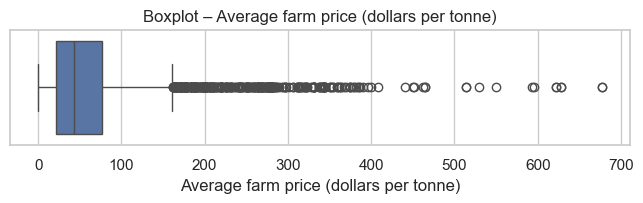

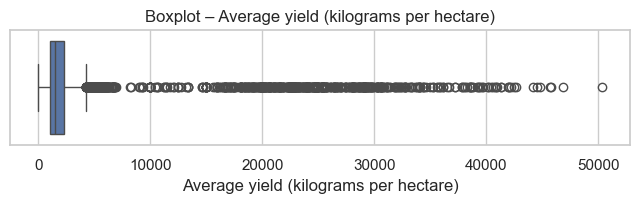

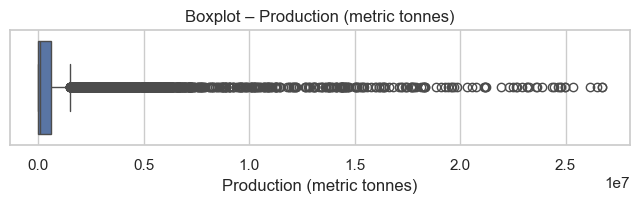

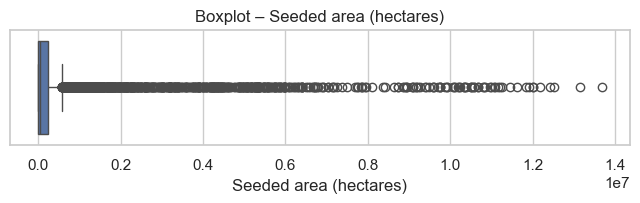

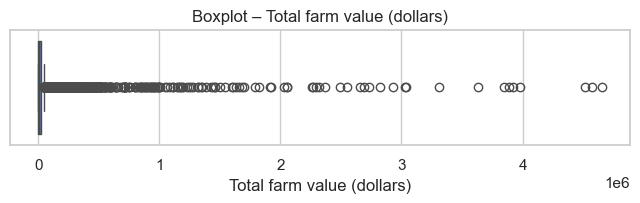

In [32]:
# List of numeric columns to inspect
numeric_cols = [
    "Average farm price (dollars per tonne)",
    "Average yield (kilograms per hectare)",
    "Production (metric tonnes)",
    "Seeded area (hectares)",
    "Total farm value (dollars)"
]

# Boxplots for visual inspection
for col in numeric_cols:
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot – {col}")
    plt.show()


### Saving the Clean Dataset

After completing all missing value treatments, outlier assessment, and preliminary data filtering, the dataset is saved in the `data_clean/` directory for future use in exploratory analysis and modeling.

This version is free of nulls and structural inconsistencies and will serve as the baseline for all future transformations.

In [33]:
# Save the cleaned dataset to the 'data_clean' folder
df.to_csv("../data_clean/farm_production_clean.csv", index=False)